In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import time, os
from torch.autograd import Variable
from modules import *

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:



def p(s):
    print(s)
    print('pausing')
    time.sleep(10000)

class MNIST:
    def __init__(self, bs=1):
        dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

        train_dataset = datasets.MNIST('data', train=True, download=True, transform=dataset_transform)
        eval_dataset = datasets.MNIST('data', train=False, download=True, transform=dataset_transform)
        
        self.train_dataloader  = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
        self.eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=bs, shuffle=True)

bs = 128
lr = 1e-3
use_cuda = True # False
optimizer = 'adam'
num_epochs = 100
disp_interval = 100
save_epoch = 1
val_epoch = 1
project_id = 'capsnet'
num_classes = 10
save_dir = 'saved_models'
num_epochs = 100

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

mnist = MNIST(bs=bs)

In [3]:
 # Variables
inputs = torch.FloatTensor(1)
labels = torch.FloatTensor(1)
eye = Variable(torch.eye(num_classes))
inputs = Variable(inputs)
labels = Variable(labels)

# Model
model = CapsNet(use_cuda=use_cuda)

# cuda
if use_cuda:
    inputs = inputs.cuda()
    labels = labels.cuda()
    model = model.cuda()
    eye = eye.cuda()

params = []

for key, value in dict(model.named_parameters()).items():
    if value.requires_grad:
        params += [{'params':[value],'lr':lr}]

# optimizer
if optimizer == "adam":
    optimizer = torch.optim.Adam(model.parameters())
elif optimizer == "sgd":
    optimizer = torch.optim.SGD(params)

criterion = CapsLoss()

print('Training started!')

for epoch in range(num_epochs):
    start = time.time()
    
    # train
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (imgs, targets) in enumerate(mnist.train_dataloader):
        if imgs.size(0) != bs:
            continue
        targets = torch.eye(num_classes).index_select(dim=0, index=targets)
        inputs.data.resize_(imgs.size()).copy_(imgs)
        labels.data.resize_(targets.size()).copy_(targets)
        
        optimizer.zero_grad()
        outputs, reconst = model(inputs)
        
        scores = torch.sqrt((outputs ** 2).sum(2))
        loss = criterion(scores, labels, reconst, inputs)
        train_loss = loss.data.cpu().numpy()[0]

        # backward
        loss.backward()
        optimizer.step()

        scores, classes = F.softmax(scores).max(dim=1)
        predicted = eye.index_select(dim=0, index=classes.squeeze(1))
        
        predicted_idx = np.argmax(predicted.data.cpu().numpy(),1)
        label_idx = np.argmax(targets.numpy(), 1)
        correct = np.sum(predicted_idx == label_idx)
        
        # info
        if batch_idx % disp_interval == 0:
            end = time.time()
            print("[epoch %2d][iter %4d] loss: %.4f, acc: %.4f%% (%d/%d)" \
                            % (epoch, batch_idx, train_loss/(batch_idx+1), 100.*correct/bs, correct, bs))

    save_name = os.path.join(save_dir, '{}_{}.pth'.format(project_id, epoch))
    if save_epoch > 0 and batch_idx % save_epoch == 0:
        torch.save({
          'epoch': epoch,
          'state_dict': model.cpu().state_dict(),
        }, save_name)
    if use_cuda:
        model.cuda()

    # val
    if epoch % val_epoch == 0:
        print('Validating...')
        correct = 0
        total = 0
        model.eval()
        for batch_idx, (imgs, targets) in enumerate(mnist.eval_dataloader):
            if imgs.size(0) != bs:
                continue
            targets = torch.eye(num_classes).index_select(dim=0, index=targets)
            inputs.data.resize_(imgs.size()).copy_(imgs)
            labels.data.resize_(targets.size()).copy_(targets)
            
            outputs, reconst = model(inputs)
            scores = torch.sqrt((outputs ** 2).sum(2))
            scores, classes = F.softmax(scores).max(dim=1)
            predicted = eye.index_select(dim=0, index=classes.squeeze(1))
        
            predicted_idx = np.argmax(predicted.data.cpu().numpy(),1)
            label_idx = np.argmax(targets.numpy(), 1)
            correct += np.sum(predicted_idx == label_idx)
            total += targets.size(0)
        print("[epoch %2d] val acc: %.4f%% (%d/%d)" \
                                % (epoch, 100.*correct/total, correct, total))

Training started!


/home/xander/cupyCapsNet/pytorch/modules.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[epoch  0][iter    0] loss: 0.7490, acc: 14.0625% (18/128)
[epoch  0][iter  100] loss: 0.0012, acc: 95.3125% (122/128)
[epoch  0][iter  200] loss: 0.0005, acc: 95.3125% (122/128)
[epoch  0][iter  300] loss: 0.0003, acc: 96.8750% (124/128)
[epoch  0][iter  400] loss: 0.0001, acc: 97.6562% (125/128)
Validating...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[epoch  0] val acc: 97.8466% (9769/9984)
[epoch  1][iter    0] loss: 0.0474, acc: 98.4375% (126/128)
[epoch  1][iter  100] loss: 0.0004, acc: 96.8750% (124/128)
[epoch  1][iter  200] loss: 0.0002, acc: 96.0938% (123/128)
[epoch  1][iter  300] loss: 0.0001, acc: 96.8750% (124/128)
[epoch  1][iter  400] loss: 0.0001, acc: 97.6562% (125/128)
Validating...
[epoch  1] val acc: 98.5276% (9837/9984)
[epoch  2][iter    0] loss: 0.0300, acc: 99.2188% (127/128)
[epoch  2][iter  100] loss: 0.0003, acc: 97.6562% (125/128)
[epoch  2][iter  200] loss: 0.0001, acc: 99.2188% (127/128)
[epoch  2][iter  300] loss: 0.0001, acc: 99.2188% (127/128)
[epoch  2][iter  400] loss: 0.0001, acc: 98.4375% (126/128)
Validating...
[epoch  2] val acc: 98.7179% (9856/9984)
[epoch  3][iter    0] loss: 0.0252, acc: 97.6562% (125/128)
[epoch  3][iter  100] loss: 0.0002, acc: 100.0000% (128/128)
[epoch  3][iter  200] loss: 0.0001, acc: 98.4375% (126/128)
[epoch  3][iter  300] loss: 0.0001, acc: 98.4375% (126/128)
[epoch  

Validating...
[epoch 24] val acc: 99.3590% (9920/9984)
[epoch 25][iter    0] loss: 0.0018, acc: 100.0000% (128/128)
[epoch 25][iter  100] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 25][iter  200] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 25][iter  300] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 25][iter  400] loss: 0.0000, acc: 100.0000% (128/128)
Validating...
[epoch 25] val acc: 99.2989% (9914/9984)
[epoch 26][iter    0] loss: 0.0015, acc: 100.0000% (128/128)
[epoch 26][iter  100] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 26][iter  200] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 26][iter  300] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 26][iter  400] loss: 0.0000, acc: 100.0000% (128/128)
Validating...
[epoch 26] val acc: 99.3289% (9917/9984)
[epoch 27][iter    0] loss: 0.0011, acc: 100.0000% (128/128)
[epoch 27][iter  100] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 27][iter  200] loss: 0.0000, acc: 100.0000% (128/128)
[epoch 27][iter  300] loss: 0.0000, acc: 1

Validating...
[epoch 47] val acc: 10.0861% (1007/9984)
[epoch 48][iter    0] loss: 0.0004, acc: 3.1250% (4/128)
[epoch 48][iter  100] loss: 0.0000, acc: 14.0625% (18/128)


KeyboardInterrupt: 

In [9]:
## Visualization
 # Variables
inputs = torch.FloatTensor(1)
labels = torch.FloatTensor(1)
eye = Variable(torch.eye(num_classes))
inputs = Variable(inputs)
labels = Variable(labels)

model_path = 'saved_models/capsnet_42.pth'
# Model
model = CapsNet(use_cuda=use_cuda)
model.load_state_dict(torch.load(model_path)['state_dict'])
# cuda
if use_cuda:
    inputs = inputs.cuda()
    labels = labels.cuda()
    model = model.cuda()
    eye = eye.cuda()

start = time.time()

# get eval output
model.eval()
correct = 0
train_loss = 0
imgs, targets = next(iter(mnist.eval_dataloader))

inputs.data.resize_(imgs.size()).copy_(imgs)

outputs, reconst = model(inputs)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/capsnet_42.pth'

In [ ]:
def show(inputs, reconst, bs):
    
    orig = inputs.data.cpu().view(bs, -1)
    orig -= orig.min(dim=1, keepdim=True)[0]
    orig /= orig.max(dim=1, keepdim=True)[0]
    disp = torch.cat([orig.view(bs, 1, 28, 28), reconst.data.cpu().view(bs, 1, 28, 28)], dim=3)
    
    img = make_grid(disp, padding=5)
    
    npimg = img.numpy()
#     fig, ax = subplots(figsize=(18, 18))
    plt.figure(figsize = (18,18))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

show(inputs, reconst, bs)

In [10]:
import matplotlib.gridspec as gridspec
from itertools import product

inpt = inputs.data.cpu().numpy()
recon = reconst.data.cpu().view(bs, 1, 28, 28).numpy()

def compare_reconst(inputs, recons, bs):
    # inputs, recons both have size (bs, 1, 28, 28)
    # bs is the batchsize
    
    fig = plt.figure(figsize=(18, 18))

    # gridspec inside gridspec
    outer_grid = gridspec.GridSpec(bs // 8, 8, wspace=0.2, hspace=0.2)

    for i in range(bs):
        inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2,
                subplot_spec=outer_grid[i], wspace=0.2, hspace=0.2)
        ax1 = plt.Subplot(fig, inner_grid[0])
        ax1.imshow(inputs[i].squeeze())
        ax1.set_xticks([])
        ax1.set_yticks([])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, inner_grid[1])
        ax2.imshow(recons[i].squeeze())
        ax2.set_xticks([])
        ax2.set_yticks([])
        fig.add_subplot(ax2)

    all_axes = fig.get_axes()

    #show only the outside spines
    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)

    plt.show()
    
# compare_reconst(inpt, recon, 128) 

NameError: name 'reconst' is not defined

8


/home/xander/pyCapsNet/cupyCapsNet/pytorch/modules.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b)


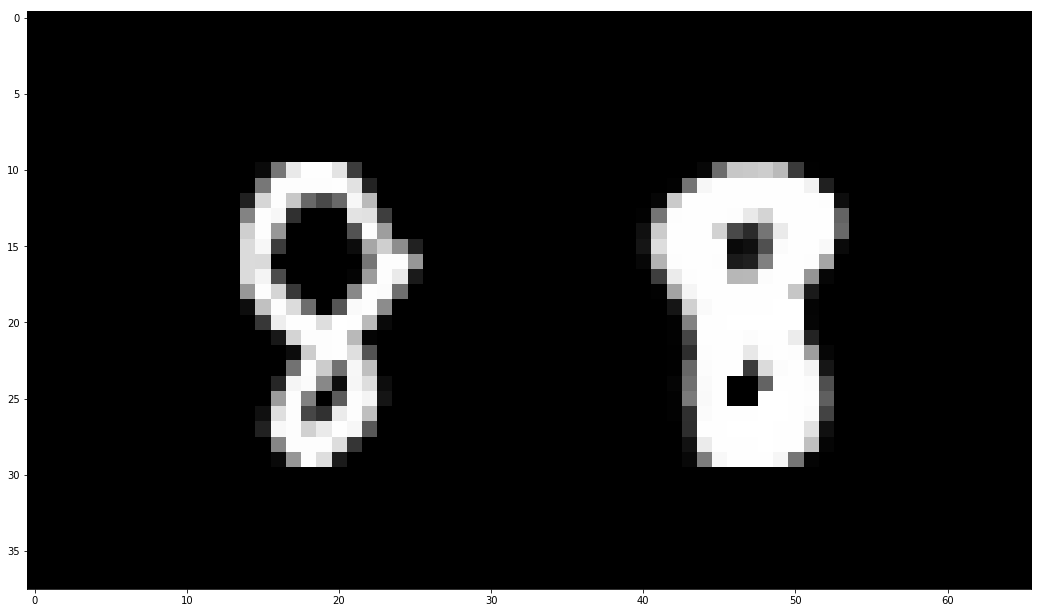

torch.Size([160, 1, 28, 28])


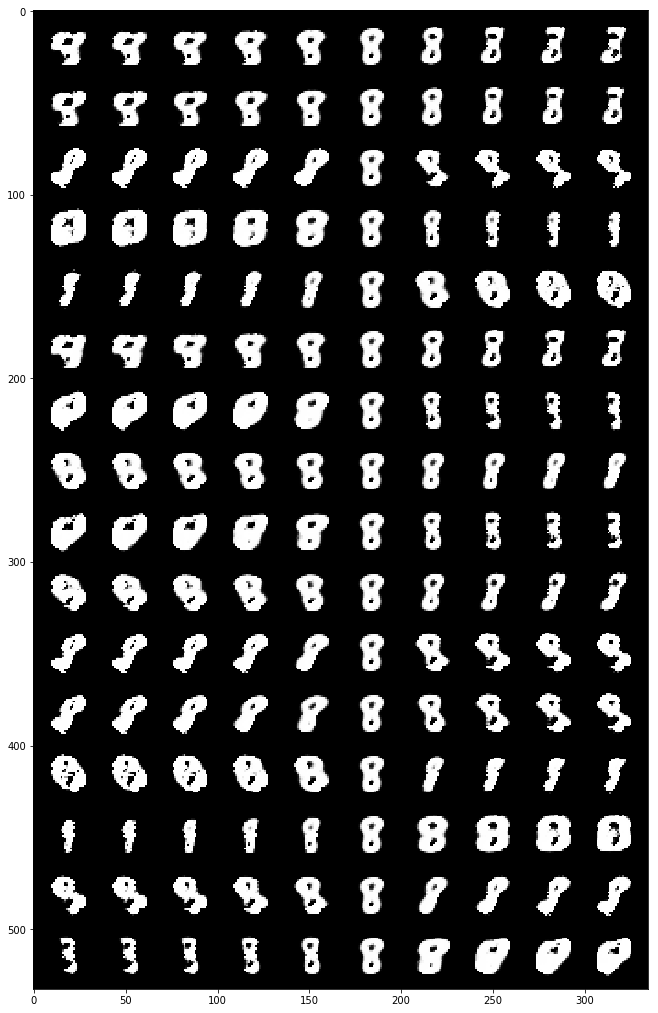

In [26]:
## Visualization
 # Variables
inputs = torch.FloatTensor(1)
labels = torch.FloatTensor(1)
eye = Variable(torch.eye(num_classes))
inputs = Variable(inputs)
labels = Variable(labels)

model_path = 'saved_models/capsnet_42.pth'
# Model
model = CapsNet(use_cuda=use_cuda)
model.load_state_dict(torch.load(model_path)['state_dict'])
decoder = model.decoder

# cuda
if use_cuda:
    inputs = inputs.cuda()
    labels = labels.cuda()
    model = model.cuda()
    eye = eye.cuda()

start = time.time()

# get eval output
model.eval()
correct = 0
train_loss = 0
imgs, targets = next(iter(mnist.eval_dataloader))
img = imgs[0].unsqueeze(0)
target = targets[0]
print(target)
inputs.data.resize_(img.size()).copy_(img)
mask = torch.zeros((1,10,16,1))
mask[:, target, :, :] = 1
mask = Variable(mask)
if use_cuda:
    mask = mask.cuda()
    
outputs, reconst = model(inputs)

show(inputs, reconst, 1)

digit_repr = outputs  * mask

recons = []
for dim in range(16):
    for perturb in np.arange(-0.25,0.25,0.05):
        p_mat = torch.zeros((1,10,16,1))
        p_mat[:, target, dim, :] = perturb
        p_mat = Variable(p_mat)
#         print(p_mat)
        if use_cuda:
            p_mat = p_mat.cuda()
        _recon = decoder(digit_repr + p_mat)
        recons.append(_recon)
recons = torch.cat(recons, dim=0)
recons = recons.view(160, 1, 28, 28)

def show_interp(recons):
    
    img = make_grid(recons, nrow=10, padding=5)
    
    npimg = img.numpy()
#     fig, ax = subplots(figsize=(18, 18))
    plt.figure(figsize = (18,18))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    
print(recons.size())
show_interp(recons.data.cpu())